In [1]:
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import numpy as np
import copy
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import imageio
import os
import re
import cStringIO as sio

from IPython.core.debugger import Tracer

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Read in all of the csv's and combine into one dataframe `data`

def addTimestampColumn(filename, df):
    search = re.search(r'_(\d+).csv$',filename)
    if search:
        df['timestamp'] = int(search.group(1))
    
def addForceOutputColumn(filename, df):
    search = re.search(r'\d+\.*\d*', filename)
    if search:
        df['force_x'] = float(search.group())

def createDFFromFile(filepath):
    """ Loads a csv file into a formatted dataframe
    """
    header = ['M'+str(i) for i in range(1,8)]
    filename = os.path.basename(filepath)
    
    df = pd.read_csv(filepath, header=None, names=header)
    # Parse the finger force vector and timestamps from the filename
    addTimestampColumn(filename, df)
    addForceOutputColumn(filename, df)
    return df
    
# collect all data csvs in `directory` into one pandas DataFrame
def loadActivationDataFromDir(directory):
    dataframes = []
    for dirname, dirnames, filenames in os.walk(directory):
        # read in all of the csv's, creating a new column for timestamp and force output
        filenames = [f for f in filenames if f.endswith(".csv")]

        for filename in filenames:
            filepath = os.path.join(dirname,filename)
            
            # load csv into dataframe with format specified by the createDFFromFile function
            df = createDFFromFile(filepath)
            dataframes.append(df)

    data = pd.concat(dataframes)
        
    return data

In [3]:
data = loadActivationDataFromDir(directory='/Users/johnpugliesi/dev/github/space/output/')
data = data.set_index('force_x')
data.head()

,M1,M2,M3,M4,M5,M6,M7,timestamp
force_x,,,,,,,,
0.09636,0.295245,0.140540,0.585558,0.931391,0.300407,0.356994,0.307082,1478719523227
0.09636,0.287956,0.137117,0.579332,0.906666,0.270849,0.355019,0.303099,1478719523227
0.09636,0.281059,0.133942,0.562146,0.886698,0.181968,0.370481,0.309356,1478719523227
0.09636,0.288866,0.137745,0.624222,0.900093,0.177367,0.385217,0.319396,1478719523227
0.09636,0.218112,0.104270,0.502991,0.673671,0.001420,0.331458,0.262728,1478719523227


In [4]:
data.describe()

,M1,M2,M3,M4,M5,M6,M7,timestamp
count,303000.000000,303000.000000,303000.000000,303000.000000,303000.000000,303000.000000,303000.000000,3.030000e+05
mean,0.180753,0.106833,0.518497,0.699693,0.475179,0.632083,0.098327,1.478696e+12
std,0.054948,0.027327,0.293412,0.208175,0.282557,0.273251,0.077007,2.380906e+08
min,0.016717,0.008619,0.000085,0.003299,0.000241,0.000071,0.000000,1.476315e+12
25%,0.143702,0.089387,0.264809,0.569824,0.231648,0.408096,0.031245,1.478720e+12
50%,0.183391,0.109337,0.531054,0.734645,0.454213,0.653311,0.083781,1.478720e+12
75%,0.215357,0.127974,0.773169,0.864532,0.716635,0.891290,0.151010,1.478720e+12
max,0.339753,0.161867,0.999545,1.000000,1.000000,1.000000,0.381499,1.478720e+12


In [5]:
def plotParaCoordActivations(df, fig, alpha=0.5, identifier='force_x'):
    #cmap = LinearSegmentedColormap.from_list('mycmap', ['white', 'purple'])
    
    #colormap = plt.cm.get_cm('Purples')
    plot = parallel_coordinates(df,identifier)

    # Set the alpha for the lines
    for line in plot.lines:
        line.set_alpha(alpha)
        
    plot.legend().set_visible(False)
    plot.set_title('Force Activations')
    plot.set_xlabel('Muscles')
    plot.set_ylabel('% Activation')
    
    return fig, plot

In [6]:
#sample = data.sample(100)
output_forces = sorted(data.index.unique())

N = len(output_forces)
n = 2
alpha = float(n)/N

print alpha
plotData = data.reset_index().drop('timestamp',axis=1)
plotData = plotData[plotData['force_x'] == output_forces[n]]
plotData.head()

0.00333889816361


,force_x,M1,M2,M3,M4,M5,M6,M7
0,0.09636,0.295245,0.140540,0.585558,0.931391,0.300407,0.356994,0.307082
1,0.09636,0.287956,0.137117,0.579332,0.906666,0.270849,0.355019,0.303099
2,0.09636,0.281059,0.133942,0.562146,0.886698,0.181968,0.370481,0.309356
3,0.09636,0.288866,0.137745,0.624222,0.900093,0.177367,0.385217,0.319396
4,0.09636,0.218112,0.104270,0.502991,0.673671,0.001420,0.331458,0.262728


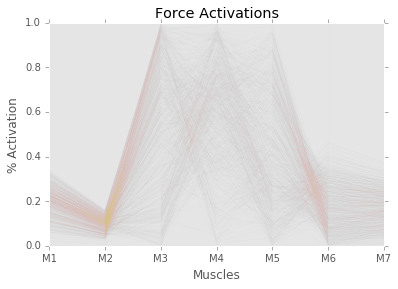

In [15]:
# Example of a parllel coordinate plot
fig = plt.figure()
plotParaCoordActivations(plotData, fig, alpha, 'force_x')
fig.savefig("ex-paracoord", format='png', dpi=1000)

In [16]:
# Generate Paracoordinate Animation for a series of plots
def createParacoordAnimation(df, filename='paracoord_animation', anim_format='gif'):
    
    output_forces = sorted(data.index.unique())
    images = []
    fig = plt.figure()

    N = len(output_forces)

    for n, force in enumerate(set(output_forces)[:N:2]):
        print force

        alpha = float(n)/N

        plotData = df.ix[force].reset_index().drop('timestamp', axis=1)

        fig, plot = plotParaCoordActivations(plotData, fig, alpha, 'force_x')

        img = sio.StringIO()
        fig.savefig(img, format='png', dpi=800)
        img.seek(0)
        images.append(imageio.imread(img))

        plt.clf()
        #plt.close(fig)
    imageio.mimsave("{filename}.{anim_format}", images)

0.0
0.0963597144986
0.192719428997
0.289079143496
0.385438857994
0.481798572493
0.578158286992
0.67451800149
0.770877715989
0.867237430487
0.963597144986
1.05995685948
1.15631657398
1.25267628848
1.34903600298
1.44539571748
1.54175543198
1.63811514648
1.73447486097
1.83083457547
1.92719428997
2.02355400447
2.11991371897
2.21627343347
2.31263314797
2.40899286246
2.50535257696
2.60171229146
2.69807200596
2.79443172046
2.89079143496
2.98715114946
3.08351086395
3.17987057845
3.27623029295
3.37259000745
3.46894972195
3.56530943645
3.66166915095
3.75802886545
3.85438857994
3.95074829444
4.04710800894
4.14346772344
4.23982743794
4.33618715244
4.43254686694
4.52890658143
4.62526629593
4.72162601043
4.81798572493
4.91434543943
5.01070515393
5.10706486843
5.20342458292
5.29978429742
5.39614401192
5.49250372642
5.58886344092
5.68522315542
5.78158286992
5.87794258441
5.97430229891
6.07066201341
6.16702172791
6.26338144241
6.35974115691
6.45610087141
6.5524605859
6.6488203004
6.7451800149
6.8415397

KeyboardInterrupt: 

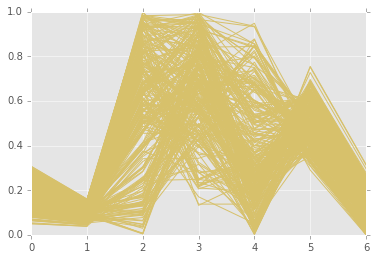

In [17]:
# Call to create the animation
createParacoordAnimation(data, anim_format="mp4")

In [10]:
def createPDFPlotForMuscle(ax, title, xs, density, x_min, x_max, y_min, y_max):
    
    ax.plot(xs,density)
    ax.set_title(title)
    ax.set_xlabel("Activation %")
    
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    return fig, ax

In [14]:
def getOutputForces(df):
    return sorted(df.index.unique())[::2]

def gaussianDensityForSeries(muscleASeries, x_range, covariance_factor=.15):
    density = gaussian_kde(muscleASeries)
    density(x_range)
    
    density.covariance_factor = lambda : covariance_factor
    density._compute_covariance()
    
    return density(x_range)

def getXYMinMax(muscleASeries, unique_forces):
    x_min = muscleASeries.min()
    x_max = muscleASeries.max()
    xs = np.linspace(x_min,x_max,200)
    
    dfs = [(min(gaussianDensityForSeries(muscleASeries.ix[force],xs)), max(gaussianDensityForSeries(muscleASeries.ix[force],xs))) for force in unique_forces]
    mins, maxs = zip(*dfs)
            
    
    y_min = min(mins)
    y_max = max(maxs)
    
    return x_min, x_max, y_min, y_max

def animatePDFForMuscleASeries(ax, muscleASeries, animation_name="pdf_animation", output_format="mp4",
                               print_force_progress=True):
    
    unique_forces = getOutputForces(muscleASeries)

    x_min, x_max, y_min, y_max = getXYMinMax(muscleASeries, unique_forces)

    xs = np.linspace(x_min,x_max,200)
    
    images = []
    for force in output_forces[0:-1]:
        if print_force_progress:
            print force
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        density = gaussianDensityForSeries(muscleASeries.ix[force], xs)
        createPDFPlotForMuscle(ax, muscleASeries.name, xs, density, x_min, x_max, y_min, y_max)
        img = sio.StringIO()
        fig.savefig(img, format='png')
        img.seek(0)
        images.append(imageio.imread(img))

        plt.clf()
        
    file_name = "{a_name}.{of}".format(a_name = animation_name, of=output_format)
    imageio.mimsave(file_name, images)

def animateAllMuscles(muscleDF):
    for muscle in muscleDF.columns:
        muscleData = muscleDF[muscle]
        
        anim_name = "pdf_{muscleName}".format(muscleName=muscle)
        animatePDFForMuscleASeries(muscleData, animation_name=anim_name)

def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, np.ndarray):
            list_flatten(i, a)
        else:
            a.append(i)
    return a
        
class MuscleSeriesPlot(object):
    
    def MuscleSeriesPlot(self):
        pass
        
def createPreAnimationMusclePlots(muscleDF):
    
    musclePlots = []

    unique_forces = getOutputForces(muscleDF)

    print "Creating Plot Data"
    for i, muscle in enumerate(muscleDF.columns):
        muscleData = muscleDF[muscle]
        
        print "Creating plot", i

        x_min, x_max, y_min, y_max = getXYMinMax(muscleData, unique_forces)
        xs = np.linspace(x_min,x_max,200)
       
        musclePlot = MuscleSeriesPlot()
        musclePlot.data = muscleData
        musclePlot.x_range = xs
        musclePlot.x_min = x_min
        musclePlot.x_max = x_max
        musclePlot.y_min = y_min
        musclePlot.y_max = y_max
        musclePlot.animation_name = "pdf_{muscleName}".format(muscleName=muscle)
        
        musclePlots.append(musclePlot)

    # we now have a list of plots to generate
    return unique_forces, musclePlots
    # for each force, plot the muscle

In [12]:
md = data.drop(["timestamp"],axis=1)
unique_forces, musclePlots = createPreAnimationMusclePlots(md)

Creating Plot Data
Creating plot 0


NameError: global name 'muscleData' is not defined